In [15]:
%matplotlib widget
from ipywidgets import interact
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,glob, socket
import tifffile as tif
import sympy as sp
import pickle
import time
ck = plt.rcParams['axes.prop_cycle'].by_key()['color']
mk = ['s','o','>','D','*','v','^']

In [16]:
def veloc_tunel(V):
    tunel_v = pd.read_csv('tunel_viento.csv',header=None)
    deltaV, U = tunel_v.to_numpy().T
    p1 = np.polyfit(deltaV,U,1)
    UdeltaV = np.poly1d(p1)
    return UdeltaV(V)
    
class camfast:
    def __init__(self,name):
        self.dir = name
        datafile = name.split('_')
        D = 50e-2
        self.th = float(datafile[1].replace('t',''))*1e-6
        self.L = float(datafile[2].replace('L',''))/100*D
        self.veloc = 1
        self.DeltaV = 1
        self.drag_i = 1
        g = 9.8
        if self.th == 75e-6:
            self.rho = 1300
            self.y1 = 37.3e-3
        elif self.th == 50e-6:
            self.rho = 1900
            self.y1 = 50.2e-3
        else:
            self.th = 10000
            self.rho = 1900
            self.y1 = 0.01


        self.B =  ((self.y1*1.103)**3)*self.rho*self.th*g # rigidez a la flexion por unidad de longitud
        self.I = (self.th)**3/12  #momento de inercia por unidad de longitud
        self.E = self.B / self.I

        self.coords = 0
        self.IM_vec0 = 0
        self.IM_vec1 = 0
        self.IM_mean = 0
        self.IM_std = 0
        self.FFT_VEC0 = 0
        self.FFT_VEC1 = 0
        self.FFT_fps = 250
        self.FFT_freqs = 0

    def flex_rig(self):
        g = 9.8
        if self.th == 75e-6:
            self.rho = 1300
            self.y1 = 37.3e-3
        elif self.th == 50e-6:
            self.rho = 1900
            self.y1 = 50.2e-3
        else:
            self.th = 10000
            self.rho = 1900
            self.y1 = 0.01
        self.B =  ((self.y1*1.103)**3)*self.rho*self.th*g # rigidez a la flexion por unidad de longitud
        self.I = (self.th)**3/12  #momento de inercia por unidad de longitud
        self.E = self.B / self.I
        


        


    

In [20]:
lista_files = np.sort(glob.glob('fastcam_objs/*.pickle'))
fastcam_objs = []
fastcam_objs_0 = []
D = 50e-3
for i, filei in enumerate(lista_files[:]):
    file_aux = open(filei, 'rb')
    A = pickle.load(file_aux)
    A.th = np.round(float(filei.split('_t')[-1][:3])*1e-6,6)
    A.L = np.round(float(filei.split('_L')[-1][:3])/100*D,4)
    A.deltaV = float(filei.split('_v')[-1].split('_')[0])
    A.veloc = veloc_tunel(A.deltaV )
    A.drag_i = []
    A.label_drag_i = []
    A.file_caso = filei
    nombre_csv_drag = f'medidas/back/Dshape_e{int(np.round(A.th*1e6,2)):02d}_L{int(np.round(A.L/D*100,3)):03d}_deltaV{int(A.deltaV):01d}*'
    nombre_csv_drag_0 = f'medidas/back/Dshape_e{int(np.round(A.th*1e6,2)):02d}_L{int(np.round(A.L/D*100,3)):03d}_deltaV{int(0):01d}*'
    lista_files_drag = glob.glob(nombre_csv_drag)
    lista_files_drag_0 = glob.glob(nombre_csv_drag_0)
    time_drag_0 = np.array([os.path.getmtime(filei) for filei in  lista_files_drag_0])
    for j,file_drag_j in enumerate(lista_files_drag):
        index_file_drag_0 = np.argmin(np.abs(os.path.getmtime(file_drag_j) - time_drag_0))
        aux = pd.read_csv(file_drag_j,header=None)
        aux0 = pd.read_csv(lista_files_drag_0[index_file_drag_0],header=None)
        A.drag_i.append(aux.iloc[:,3].to_numpy()-aux0.iloc[:,3].mean())
        A.label_drag_i.append((file_drag_j,lista_files_drag_0[index_file_drag_0]))
        #if j==1:
        #    raise ValueError()
        #print(index_file_drag_0)
    A.drag_i_mean = []        
    for drag_i in A.drag_i:
        A.drag_i_mean.append(drag_i.mean())
    A.flex_rig()
    nombre_csv_cam = f'output_fastcam/t{int(np.round(A.th*1e6,2)):03d}L{int(np.round(A.L/D*100,3)):03d}v{int(A.deltaV):01d}*'
    lista_files_cam = glob.glob(nombre_csv_cam)
    A.coords_cam = []
    A.deltay = []
    A.files_cam = []
    for j,file_cam_j in enumerate(lista_files_cam):
        aux2 = pd.read_csv(file_cam_j)#,header=None)
        A.coords_cam.append(aux2.to_numpy())
        A.files_cam.append(file_cam_j)
    #for coords in A.coords_cam:    
    #    deltayi1 = -coords[1,2] + coords[1,1]
    #    deltayi2 = coords[2,2] - coords[3,2]
    #    A.deltay.append((deltayi1,deltayi2))
    #A.deltaymax = np.max(A.deltay)


    if A.deltaV != 0:
        fastcam_objs.append(A)
    else:
        fastcam_objs_0.append(A)
    #fastcam_objs.append(A)
    file_aux.close()
        
    #if i==1:raise ValueError()

In [21]:
A.IM_vec0.shape

(2180, 60)

In [22]:
for j,file_drag_j in enumerate(lista_files_drag):
    index_file_drag_0 = np.argmin(np.abs(os.path.getmtime(file_drag_j) - time_drag_0))
    aux = pd.read_csv(file_drag_j,header=None)

In [23]:
[os.path.getctime(filei) for filei in  lista_files_drag_0]

[1733428470.421003, 1733428470.421003, 1733428470.421003]

In [24]:
lista_files_drag,lista_files_drag_0

(['medidas/back/Dshape_e75_L150_deltaV56_1'],
 ['medidas/back/Dshape_e75_L150_deltaV0_2',
  'medidas/back/Dshape_e75_L150_deltaV0_1',
  'medidas/back/Dshape_e75_L150_deltaV0_0'])

In [25]:
[os.path.getctime(filei) for filei in  lista_files_drag]

[1733428470.4300027]

In [26]:
lista_files_drag

['medidas/back/Dshape_e75_L150_deltaV56_1']

[array([['x0', 227.18614718614717, 732.5367965367966],
        ['x1', 761.9047619047619, 739.4632034632035],
        ['x2', 224.4155844155844, 314.7359307359308],
        ['x3', 766.0606060606061, 299.4978354978356]], dtype=object)]

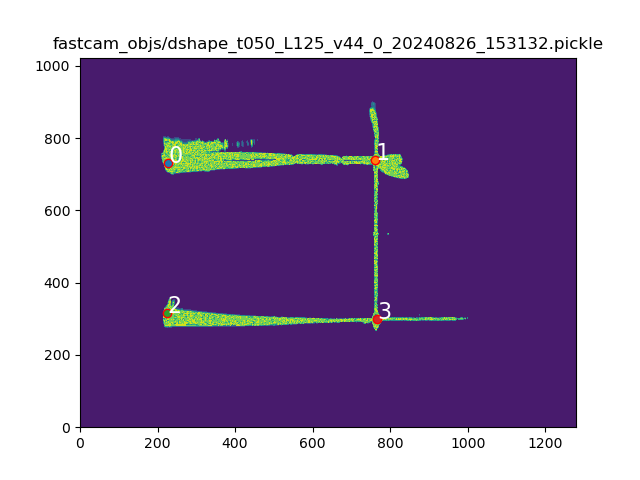

In [27]:
A = fastcam_objs[29]
fig,ax   = plt.subplots()
ax.contourf(A.IM_mean)
for i,coord in enumerate(A.coords_cam[0]):
    xi,yi = coord[1:]
    ax.plot(xi,yi,marker = 'o',markeredgecolor='r',markerfacecolor=None)
    ax.text(xi,yi,'%0d'%i,fontsize=16,color='w')
ax.set_title(A.file_caso);

A.coords_cam

[array([['x0', 227.18614718614717, 735.3073593073593],
        ['x1', 761.9047619047619, 739.4632034632035],
        ['x2', 223.030303030303, 303.65367965367966],
        ['x3', 766.0606060606061, 299.4978354978356]], dtype=object)]

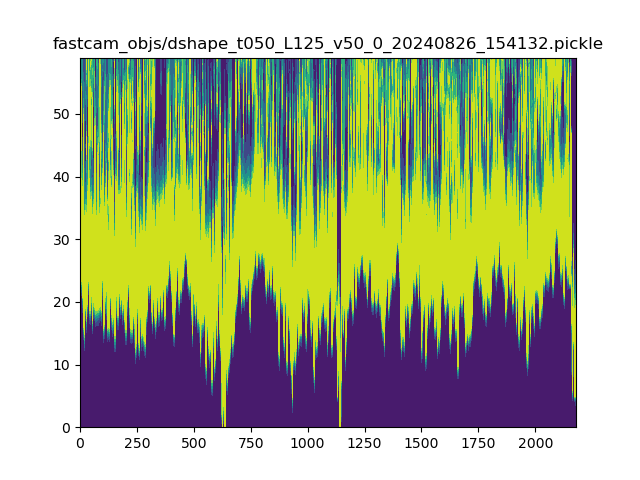

In [28]:
A = fastcam_objs[32]
fig,ax   = plt.subplots()
ax.contourf(A.IM_vec1.T)

ax.set_title(A.file_caso);

A.coords_cam

/home/juan/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


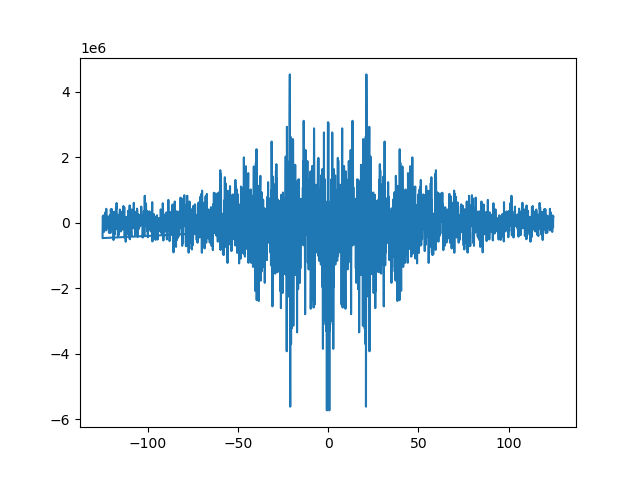

In [13]:
fig,ax = plt.subplots()
ax.plot(A.FFT_freqs,A.FFT_VEC1.sum(1))

[('medidas/back/Dshape_e50_L075_deltaV50_2', 'medidas/back/Dshape_e50_L075_deltaV0_1'), ('medidas/back/Dshape_e50_L075_deltaV50_1', 'medidas/back/Dshape_e50_L075_deltaV0_1'), ('medidas/back/Dshape_e50_L075_deltaV50_0', 'medidas/back/Dshape_e50_L075_deltaV0_1')]


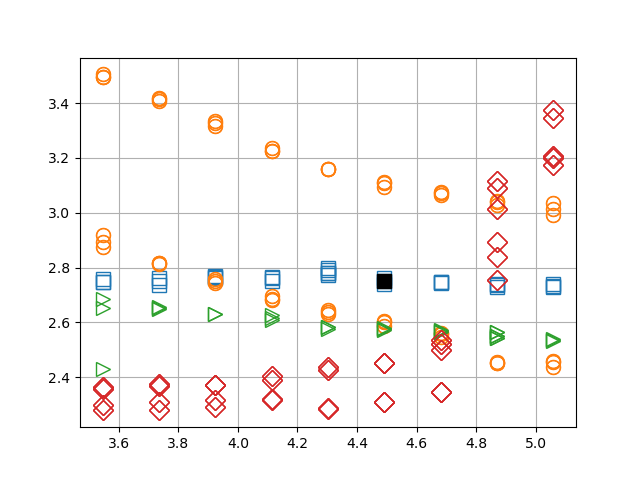

In [79]:
index_th50 = np.nonzero(np.array([A.th for A in fastcam_objs])==50e-6)[0]

Lengths = np.arange(0.75,1.75,0.25)
fig,ax = plt.subplots()
ij = 0
for i,index_i  in enumerate(index_th50):
    caso_cam = fastcam_objs[index_i]
    for j,Li in enumerate(Lengths[:]):
        if np.round(caso_cam.L/D,4)==Li:
            for k,dragi in enumerate(caso_cam.drag_i_mean):
                lin, = ax.plot(caso_cam.veloc,dragi/caso_cam.veloc**2,marker= mk[j],color=ck[j],fillstyle='none',markersize=10)
                #ax.text(caso_cam.veloc,dragi/caso_cam.veloc**2,f'$\\delta={caso_cam.deltay[0][1]:.0f}$',color=lin.get_color())
                #ax.text(caso_cam.veloc,dragi/caso_cam.veloc**2,f'$\\delta={caso_cam.deltay[0][0]:.0f}$',color='k')
                #ax.text(caso_cam.veloc+.1,dragi/caso_cam.veloc**2,f'$\\delta={caso_cam.deltay[0][1]:.0f}$',color=lin.get_color())
                ij += 1
                if ij == 20:
                    print(caso_cam.label_drag_i)
                    ax.plot(caso_cam.veloc,dragi/caso_cam.veloc**2,marker= mk[j],color='k',markersize=10)
                    
ax.grid()

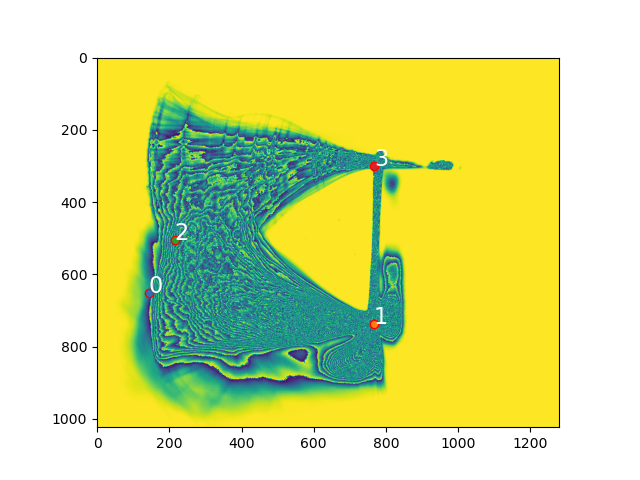

In [93]:
fig,ax = plt.subplots()
ax.imshow(caso_cam.IM_mean,cmap='viridis_r')
for i,coord in enumerate(caso_cam.coords_cam[0]):
    xi,yi = coord[1:]
    ax.plot(xi,yi,marker = 'o',markeredgecolor='r',markerfacecolor=None)
    ax.text(xi,yi,'%0d'%i,fontsize=16,color='w')

In [7]:
caso_cam.files_cam

['output_fastcam/t050L150v56_0.csv', 'output_fastcam/t050L150v56_1.csv']

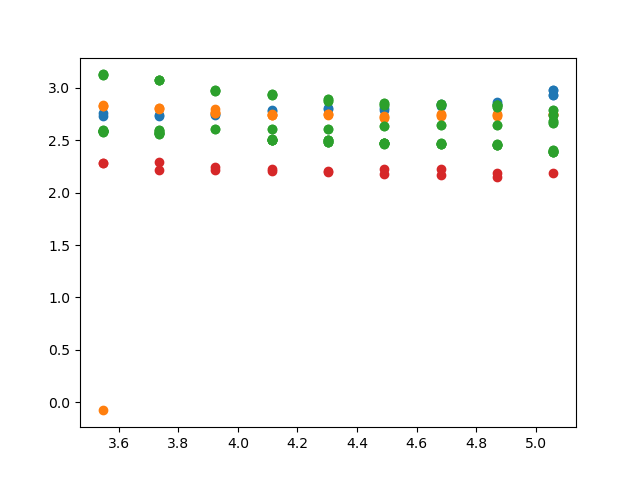

In [8]:
index_th75 = np.nonzero(np.array([A.th for A in fastcam_objs])==75e-6)[0]


Lengths = np.arange(0.75,1.75,0.25)

fig,ax = plt.subplots()
for i,index_i  in enumerate(index_th75):
    caso_cam = fastcam_objs[index_i]
    for j,Li in enumerate(Lengths):
        if np.round(caso_cam.L/D,4)==Li:
            for dragi in caso_cam.drag_i_mean:
                ax.plot(caso_cam.veloc,dragi/caso_cam.veloc**2,'o',color=ck[j])

In [10]:
A.files_cam

['output_fastcam/t050L100v40_0.csv', 'output_fastcam/t050L100v40_1.csv']

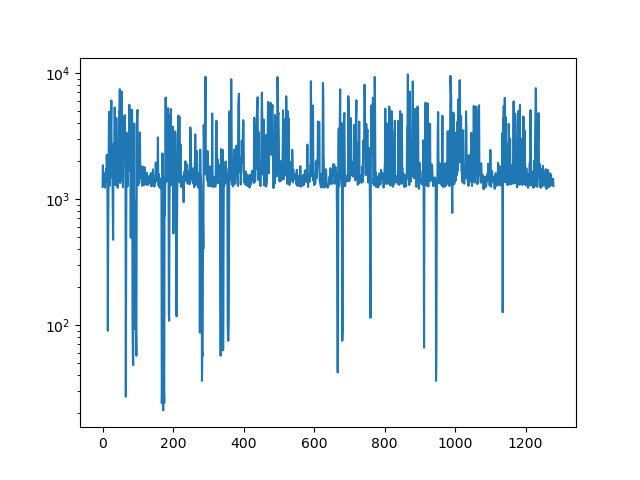

In [106]:
im = plt.imread('test1.jpeg')
fig,ax = plt.subplots()
#ax.imshow(im)
IM = np.abs(np.fft.fft(im)).sum(0).sum(1)

ax.semilogy(IM)




(1280,)